# Домашнее задание 2. Классификация изображений.

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.34. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры лучше используйте Adam c параметрами по умолчанию как стартовую точку.
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
import wandb
from wandb_key import API_KEY

wandb.login(key=API_KEY)

import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dima-malinitskiy (dima-malinitskiy-hse-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), #оно хочет кушать такое
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225]) # ImageNet на семе рассказывали
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])
])

In [4]:
train_dataset = ImageFolder('/home/user/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/home/user/dataset/val', transform=val_transform)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.DEFAULT)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 100)

    def _forward(self, x):
        return self.model(x)

    def forward(self, images, target=None):
        output = self._forward(images)
        if target is not None:
            loss = nn.CrossEntropyLoss()(output, target)
            return output, loss
        else:
            return output
    def get_accuracy(self, reset=False):
        pass 

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super(YourModule, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x, y = x.to(self.device), y.to(self.device)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = accuracy(preds.softmax(dim=-1), y, task="multiclass", num_classes=100)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x, y = x.to(self.device), y.to(self.device)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = accuracy(preds.softmax(dim=-1), y, task="multiclass", num_classes=100)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

In [ ]:
wandb_logger = WandbLogger(
    project="task 2", 
    log_model='all'
)

model = YourNet()
module = YourModule(model)

trainer = pl.Trainer(logger=wandb_logger, accelerator='gpu', max_epochs=30)
trainer.fit(module, train_dataloader, val_dataloader)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/user/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 104MB/s]  
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | YourNet          | 58.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
58.3 M    Trainable params
0         Non-trainable params
58.3 M    Total params
233.395   Total estimated model params size (MB)
425       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Валидация результатов задания

In [11]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = model(images)
            acc_batch = (preds.argmax(dim=1) == labels).float().mean().item()
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

accuracy = evaluate_task(module, val_dataloader)
print(accuracy)
print(f"Оценка за это задание составит {np.clip(5 * (accuracy - 0.24) / 0.1, 0, 5):.2f} баллов")

100%|██████████| 79/79 [00:06<00:00, 11.88it/s]

0.40901898734177217
Оценка за это задание составит 5.00 баллов


In [ ]:
torch.save(model.state_dict(), 'task2_best.pth')
# веса лежат тут, если интересно https://disk.yandex.ru/d/1mvUlkrTVnQOEw

# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

https://api.wandb.ai/links/dima-malinitskiy-hse-university/j4cswqn8 больше не чего сказать

А ну ладно ещё можно поныть, что я на это 250 рублей потратил, но не о чем не жалею 

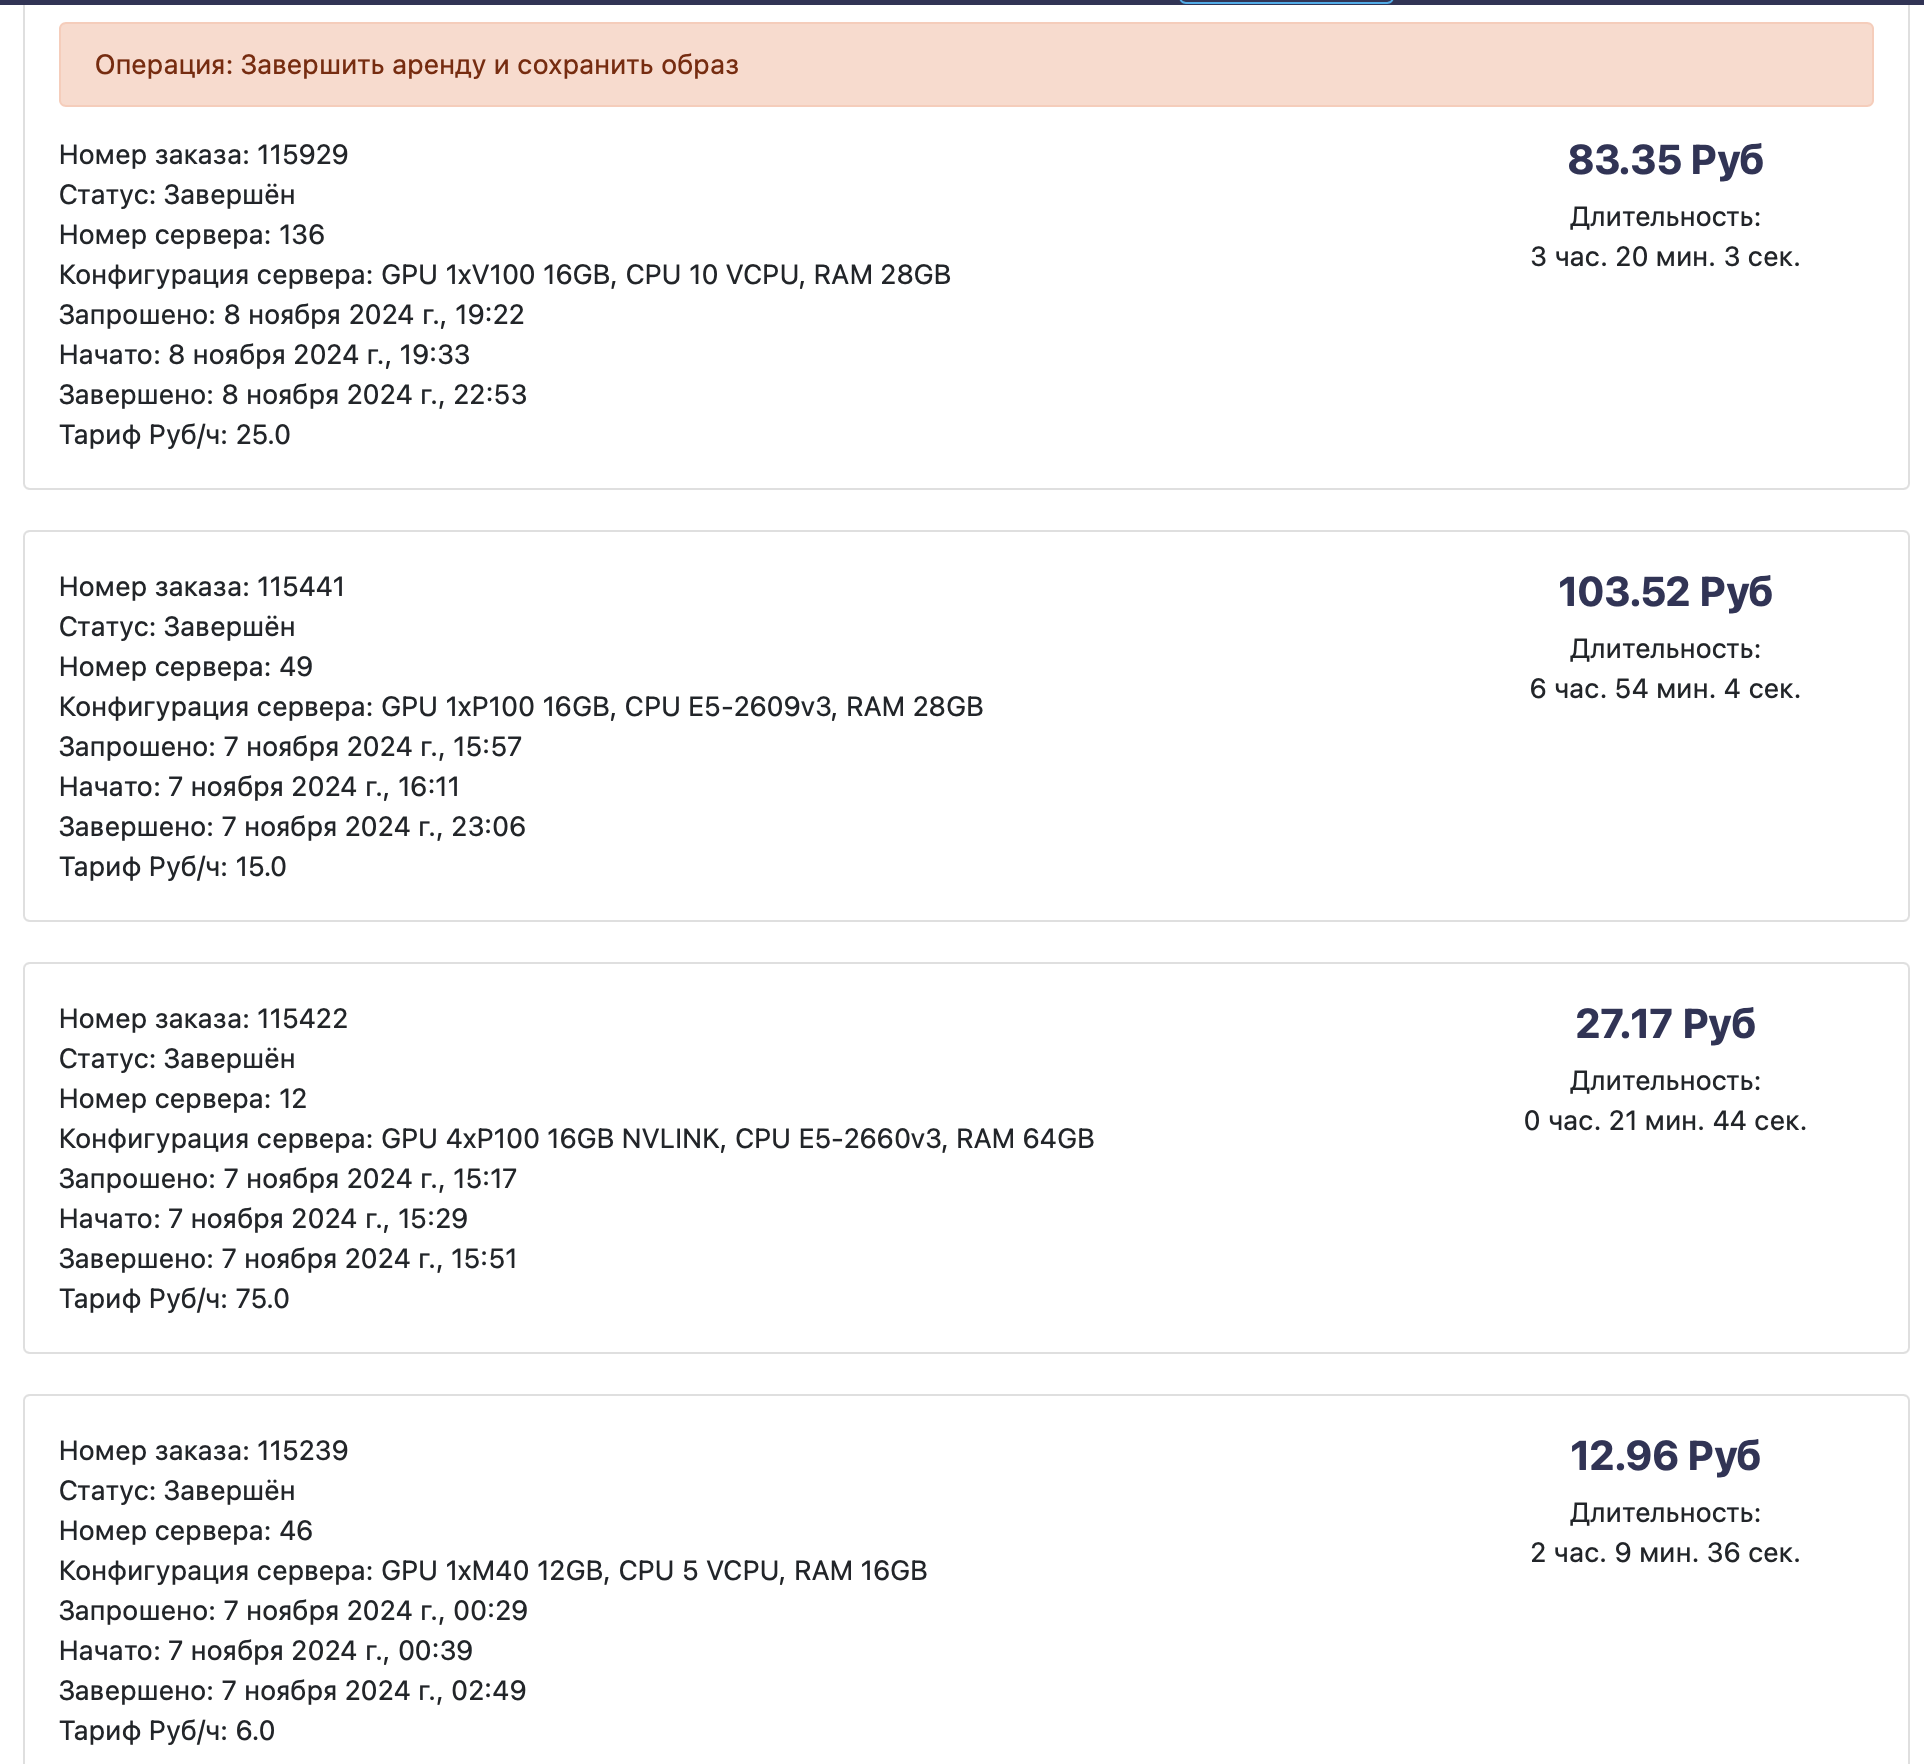